<a href="https://colab.research.google.com/github/Sabha95/Machine_Learning-Assig/blob/main/Getting_started_Notebook_for_Students_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CA684 Machine Learning Assignment Spring 2024

Dublin City University has teamed up with **Etsy** to create the 2024 CA684 Machine Learning assignment.

## Etsy.com

Etsy is the global marketplace for unique and creative goods. It’s home to a universe of special, extraordinary items, from unique handcrafted pieces to vintage treasures. Etsy operates two-sided online marketplaces that collectively connect nearly 100 million passionate and creative buyers and 7.7 million sellers around the world.

Buyers come to the Etsy marketplace for meaningful, one-of-a-kind items handcrafted and curated with passion and expertise by our creative entrepreneurs. We are focused on attracting potential buyers to Etsy for everyday items that have meaning and those “special” purchase occasions that happen throughout the year. These include items that reflect an individual’s unique style; gifting that demonstrates thought and care; and celebrations that express creativity and fun.

On Etsy, someone searches for …
- Wall art every two seconds
- Wedding-related items every two seconds
- Gift-related items every second
- Antique or vintage items every half a second

## Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers. You are provided a subset of those products as the training data.

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- top category id
- bottom category id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category). Your approaches and models will be benchmarked against a hidden test dataset.

Bonus points will be given for submissions that:

- visualize some learned representations or embeddings and show that similar items cluster together
- compares the performance of pre-trained embeddings taken from hubs or papers with a fine-tuned model


## Getting Started

Here is some sample code to get you started on the challenge!

Happy Hacking!

In [ ]:
pip install tensorflow

In [ ]:
# libraries
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics
from sklearn.feature_selection import chi2, mutual_info_classif
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# set random seed
np.random.seed(seed=42)

## Dataset

The train and test datasets are shared in **parquet** format.

In order to download the dataset, please sign the NDA first.

In [ ]:
PATH = f"/content/gdrive/MyDrive/machine_learning_Assignment"
!ls {PATH}
parquet_filenames_train = !ls {PATH}/train

filenames_string = " ".join(parquet_filenames_train)
parquet_filenames_train = filenames_string.split()
parquet_filenames_train[:3]

f"Number of files in train: {len(parquet_filenames_train):,}"

'Getting-started Notebook for Students 2025.ipynb'   test   train  'Untitled document.gdoc'


'Number of files in train: 362'

In [ ]:
parquet_filenames_test = !ls {PATH}/test
filenames_string = " ".join(parquet_filenames_test)
parquet_filenames_test = filenames_string.split()


In [ ]:
parquet_filenames_test[:3]

['part-00000-of-00362.parquet.parquet',
 'part-00181-of-00362.parquet.parquet',
 'part-00001-of-00362.parquet.parquet']

In [ ]:
f"Number of files in test: {len(parquet_filenames_test):,}"

'Number of files in test: 362'

## Exploratory Data Analysis

It is important to familiarize yourself with the dataset by using measures of centrality (e.g. mean) and statistical dispersion (e.g. variance) and data visualization methods. The following is just some Pandas preprocessing and Matplotlib visualizations to get you started. Feel free to explore the data much further and come up with ideas that might help you in the task!

### Training Dataset

This dataset can be used to train models and learn patterns from.

In [ ]:
from pandas import ExcelWriter
from google.colab import files
writer = ExcelWriter('my_excel_file.xlsx')

In [ ]:

def read_data(folder, filenames):
    """ Read parquet data from mutiple files """

    dataframes = [
        pd.read_parquet(f"{PATH}/{folder}/{filename}")
        for filename in filenames

    ]

    return pd.concat(dataframes)

In [ ]:
df_train = read_data("train", parquet_filenames_train)



**Starting Feature selection**


Cramér's V Results:
               Feature  Cramér's V
1           craft_type    0.209483
3             material    0.196217
2            recipient    0.177280
4             occasion    0.173182
6          art_subject    0.137554
9              pattern    0.108883
10  primary_color_text    0.102762
0                 room    0.101867
5              holiday    0.082195
8                shape    0.079161
7                style    0.057330

Mutual Information Results:
               Feature  MI Score
1           craft_type  0.232086
3             material  0.146642
4             occasion  0.140020
2            recipient  0.083623
10  primary_color_text  0.069475
9              pattern  0.057681
0                 room  0.055920
5              holiday  0.045186
6          art_subject  0.036419
7                style  0.018732
8                shape  0.017138


<ipython-input-13-0805dc9c4bf4>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Feature", y="MI Score", data=mi_results, palette="viridis")


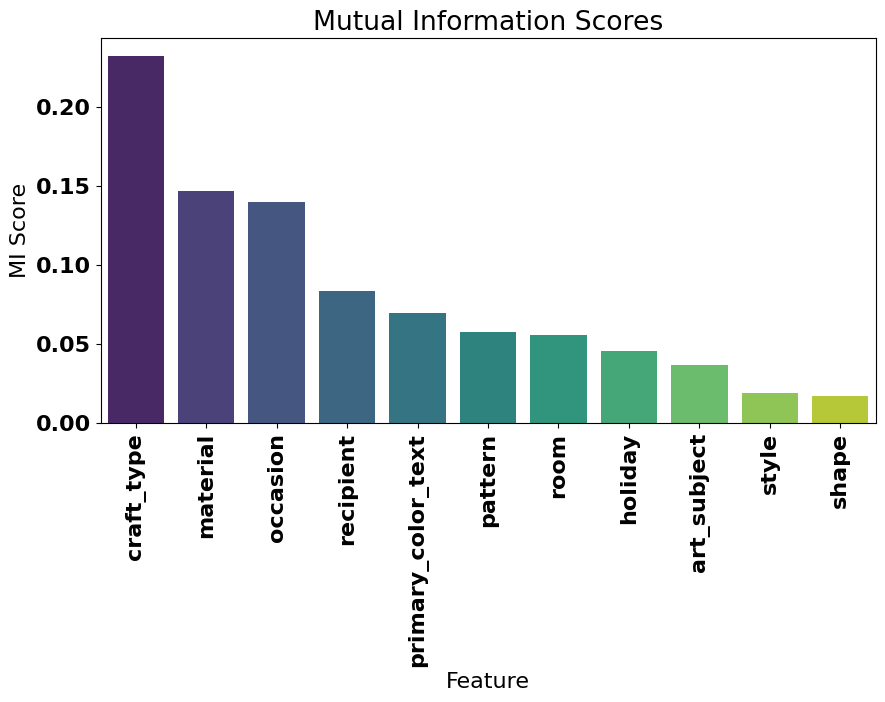

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Define categorical features
categorical_features = ["room", "craft_type", "recipient", "material", "occasion",
                        "holiday", "art_subject", "style", "shape", "pattern",
                        "primary_color_text"]

# Target variable
target = "top_category_id"

# Encode target if it's categorical
encoder = LabelEncoder()
df_train[target] = encoder.fit_transform(df_train[target])

# Encode categorical features
for col in categorical_features:
    df_train[col] = encoder.fit_transform(df_train[col])

# ------------------ 1. Cramér's V ------------------
def cramers_v(x, y):
    """ Compute Cramér's V for categorical variables """
    confusion_matrix = pd.crosstab(x, y)
    chi2_stat = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2_stat / (n * (min(r, k) - 1)))

# Compute Cramér's V for each categorical feature
cramers_results = {col: cramers_v(df_train[col], df_train[target]) for col in categorical_features}
cramers_df = pd.DataFrame(cramers_results.items(), columns=["Feature", "Cramér's V"])
cramers_df.sort_values(by="Cramér's V", ascending=False, inplace=True)

print("\nCramér's V Results:")
print(cramers_df)

# ------------------ 2. Mutual Information (MI) ------------------
mi_scores = mutual_info_classif(df_train[categorical_features], df_train[target], discrete_features=True)
mi_results = pd.DataFrame({"Feature": categorical_features, "MI Score": mi_scores})
mi_results.sort_values(by="MI Score", ascending=False, inplace=True)

print("\nMutual Information Results:")
print(mi_results)

# ------------------ 3. Visualization ------------------
plt.figure(figsize=(10, 5))
sns.barplot(x="Feature", y="MI Score", data=mi_results, palette="viridis")
plt.xticks(rotation=90)
plt.title("Mutual Information Scores")
plt.show()


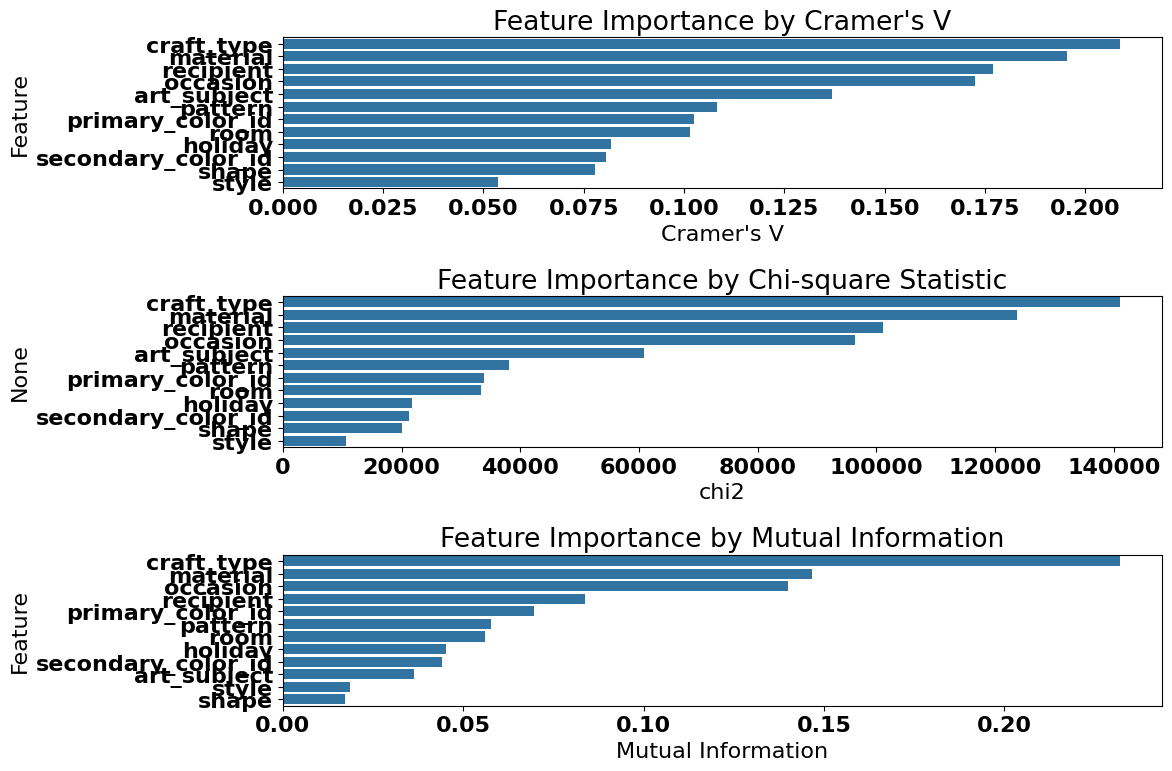


Top Features by Cramer's V:
       Feature  Cramer's V
1   craft_type    0.208687
3     material    0.195378
2    recipient    0.176978
4     occasion    0.172406
6  art_subject    0.136939

Top Features by Chi-square:
                      chi2  p_value
craft_type   141072.344912      0.0
material     123770.717408      0.0
recipient    101033.090434      0.0
occasion      96416.741043      0.0
art_subject   60826.033549      0.0

Top Features by Mutual Information:
             Feature  Mutual Information
1         craft_type            0.232086
3           material            0.146642
4           occasion            0.140020
2          recipient            0.083623
10  primary_color_id            0.069475

Combined Feature Ranking:
               Feature  Cramer_V_Rank  Chi2_Rank  MI_Rank   Avg_Rank
1           craft_type              0          0        0   0.000000
3             material              1          1        1   1.000000
2            recipient              2          

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2, mutual_info_classif
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2_stat = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2_stat / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Load your dataset (replace 'your_data.csv' with your actual file)
# df = pd.read_csv('your_data.csv')
# If you're data is in another format, adjust accordingly

# For demonstration, I'll assume your dataframe is already loaded as df
# Categorical variables to analyze
cat_vars = ['room', 'craft_type', 'recipient', 'material', 'occasion',
            'holiday', 'art_subject', 'style', 'shape', 'pattern',
            'primary_color_id', 'secondary_color_id']

# Target variable
target = 'top_category_id'

# 1. Calculate Cramer's V for all categorical variables against the target
cramer_results = {}
for var in cat_vars:
    try:
        cramer_results[var] = cramers_v(df_train[var],df_train[target])
    except (ValueError, KeyError) as e:
        print(f"Error calculating Cramer's V for {var}: {e}")
        cramer_results[var] = np.nan

# Sort results by correlation strength
cramer_df = pd.DataFrame(list(cramer_results.items()), columns=['Feature', 'Cramer\'s V'])
cramer_df = cramer_df.sort_values('Cramer\'s V', ascending=False)

# 2. Chi-square test for independence
chi2_results = {}
for var in cat_vars:
    try:
        # Create contingency table
        contingency = pd.crosstab(df_train[var], df_train[target])
        # Calculate chi-square and p-value
        chi2_stat, p_val, _, _ = chi2_contingency(contingency)
        chi2_results[var] = {'chi2': chi2_stat, 'p_value': p_val}
    except (ValueError, KeyError) as e:
        print(f"Error calculating Chi-square for {var}: {e}")
        chi2_results[var] = {'chi2': np.nan, 'p_value': np.nan}

# Convert to DataFrame for easier viewing
chi2_df = pd.DataFrame(chi2_results).T
chi2_df = chi2_df.sort_values('chi2', ascending=False)

# 3. Mutual Information
mi_results = {}
for var in cat_vars:
    try:
        # Convert to numeric labels if needed
        x = pd.factorize(df_train[var])[0]
        y = pd.factorize(df_train[target])[0]
        # Calculate mutual information
        mi = mutual_info_classif(x.reshape(-1, 1), y, discrete_features=True)[0]
        mi_results[var] = mi
    except (ValueError, KeyError) as e:
        print(f"Error calculating Mutual Information for {var}: {e}")
        mi_results[var] = np.nan

# Convert to DataFrame
mi_df = pd.DataFrame(list(mi_results.items()), columns=['Feature', 'Mutual Information'])
mi_df = mi_df.sort_values('Mutual Information', ascending=False)

# Visualizing results
plt.figure(figsize=(12, 8))

# Plot Cramer's V results
plt.subplot(3, 1, 1)
sns.barplot(x='Cramer\'s V', y='Feature', data=cramer_df)
plt.title('Feature Importance by Cramer\'s V')

# Plot Chi-square results
plt.subplot(3, 1, 2)
sns.barplot(x='chi2', y=chi2_df.index, data=chi2_df.reset_index())
plt.title('Feature Importance by Chi-square Statistic')

# Plot Mutual Information results
plt.subplot(3, 1, 3)
sns.barplot(x='Mutual Information', y='Feature', data=mi_df)
plt.title('Feature Importance by Mutual Information')

plt.tight_layout()
plt.show()

# Print top features by each metric
print("\nTop Features by Cramer's V:")
print(cramer_df.head())

print("\nTop Features by Chi-square:")
print(chi2_df.head())

print("\nTop Features by Mutual Information:")
print(mi_df.head())

# Create a combined ranking
features_ranking = pd.DataFrame({'Feature': cat_vars})
features_ranking['Cramer_V_Rank'] = [list(cramer_df['Feature']).index(f) if f in list(cramer_df['Feature']) else np.nan for f in cat_vars]
features_ranking['Chi2_Rank'] = [chi2_df.index.get_loc(f) if f in chi2_df.index else np.nan for f in cat_vars]
features_ranking['MI_Rank'] = [list(mi_df['Feature']).index(f) if f in list(mi_df['Feature']) else np.nan for f in cat_vars]
features_ranking['Avg_Rank'] = features_ranking[['Cramer_V_Rank', 'Chi2_Rank', 'MI_Rank']].mean(axis=1)
features_ranking = features_ranking.sort_values('Avg_Rank')

print("\nCombined Feature Ranking:")
print(features_ranking)

Droping Unwanted columns

In [ ]:
columns_to_drop = ['product_id', 'type', 'room', 'holiday', 'art_subject', 'style', 'shape', 'pattern', 'primary_color_id', 'secondary_color_id', 'secondary_color_text']
df_train = df_train.drop(columns=columns_to_drop, errors='ignore')


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif
import numpy as np


# Fill NaN values in text columns
text_columns = ['title', 'description', 'tags']
for col in text_columns:
    df_train[col] = df_train[col].fillna('')

# Process each text column
for text_col in text_columns:
    print(f"\nAnalyzing {text_col}...")

    # Convert text to numerical features using TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(df_train[text_col])

    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Calculate chi-square values for top_category_id
    chi2_values, p_values = chi2(X, df_train['top_category_id'])
    # Convert the sparse matrix to a dense array
    X_dense = X.toarray()

    # Calculate mutual information
    mi_values = mutual_info_classif(X_dense, df_train['top_category_id'], discrete_features=False)

    # Create a DataFrame with word importance metrics
    word_importance = pd.DataFrame({
        'word': feature_names,
        'chi2': chi2_values,
        'p_value': p_values,
        'mutual_info': mi_values
    })

    # Sort by mutual information (generally more reliable for text)
    top_words = word_importance.sort_values('mutual_info', ascending=False).head(20)
    print(f"Top 20 words in {text_col} associated with top_category_id:")
    print(top_words)

    # Optionally do the same for bottom_category_id
    # chi2_values_bottom, p_values_bottom = chi2(X, df['bottom_category_id'])
    # mi_values_bottom = mutual_info_classif(X, df['bottom_category_id'])
    # etc.


Analyzing title...


ValueError: Sparse matrix `X` can't have continuous features.

In [ ]:
df_train.to_csv('my_excel_file.csv', index=False)

# files.download('my_excel_file.csv')

In [ ]:
df_csv = pd.read_csv('my_excel_file.csv')

<ipython-input-18-e7d553a95a36>:1: DtypeWarning: Columns (5,8,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csv = pd.read_csv('my_excel_file.csv')


In [ ]:
print(df_train.info())  # Check data types and missing values
print(df_train.describe())  # Summary statistics

<class 'pandas.core.frame.DataFrame'>
Index: 229624 entries, 0 to 91
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   product_id            229624 non-null  int64 
 1   title                 229624 non-null  object
 2   description           229624 non-null  object
 3   tags                  229624 non-null  object
 4   type                  229624 non-null  object
 5   room                  229624 non-null  object
 6   craft_type            229624 non-null  object
 7   recipient             229624 non-null  object
 8   material              229624 non-null  object
 9   occasion              229624 non-null  object
 10  holiday               229624 non-null  object
 11  art_subject           229624 non-null  object
 12  style                 229624 non-null  object
 13  shape                 229624 non-null  object
 14  pattern               229624 non-null  object
 15  bottom_category_id    2296

In [ ]:
type(df_csv)
(df_csv.applymap(lambda x: x.isspace() if isinstance(x, str) else False)).sum()


# print(df_train.isnull().sum())  # Count missing values in each column
# print(df_train == "").sum()
# df.fillna(df_train.median(), inplace=True)  # Replace missing values with median


<ipython-input-19-60a4fc430d55>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  (df_csv.applymap(lambda x: x.isspace() if isinstance(x, str) else False)).sum()


,0
product_id,0
title,0
description,0
tags,0
type,0
room,0
craft_type,0
recipient,0
material,0
occasion,0


In [ ]:
f"Number of rows in train: {len(df_train):,}"

'Number of rows in train: 229,624'

In [ ]:
f"Number of unique products in train: {len(df_train['product_id'].unique()):,}"

'Number of unique products in train: 229,624'

In [ ]:
f"Number of columns in train: {len(df_train.columns):,}"

'Number of columns in train: 23'

In [ ]:
list(df_train.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text']

In [ ]:
df_train.iloc[0]

,0
product_id,699437355
title,Children&#39;s circle skirt BLUE GALAXY made o...
description,The fuxandfriends children&#39;s full circle s...
tags,
type,physical
room,
craft_type,
recipient,
material,
occasion,


In [ ]:
df_train.head(10)

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,shape,pattern,bottom_category_id,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,physical,,,,,,...,,,426,clothing.girls_clothing.skirts,5,clothing,2,blue,2,blue
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,,,,,birthday,...,,animal print,426,clothing.girls_clothing.skirts,5,clothing,11,pink,1,black
2,1142910558,"Zebra print tutu, animal print Skirt, World bo...",All tutus are handmade to order with two layer...,"black and white tutu,striped skirt,zebra tutu,...",physical,,,,,,...,,animal print,426,clothing.girls_clothing.skirts,5,clothing,17,white,1,black
3,1320296928,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",Step aside because the princess pop star is he...,"tutu,girls skirt,sparkling tutu,fun skirt,ball...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,12,purple,13,rainbow
4,854901795,Bumblebee tutu yellow and black tutu halloween...,"Sparkle, shimmer, twirl and spin,\nThis tutu&#...","dog tutu,fluffy tutu,dance tutu,skirt,flower g...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,18,yellow,1,black
5,685174923,"Mexican Girl Outfit, 1st Birthday Fiesta Outfi...",Tutu is hand tied on pink ribbon. \nSkirt and ...,"Tutu Skirt,Fabric Tutu,Fabric Skirt,Birthday O...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,11,pink,13,rainbow
6,705540552,Purple and Aqua tutu birthday tutu pony tutu u...,"Sparkle, shimmer, twirl and spin,\nThis tutu&#...","spring tutu,smash cake,photo prop,dog tutu,Tut...",physical,,,,,birthday,...,,striped,426,clothing.girls_clothing.skirts,5,clothing,12,purple,9,green
7,530355856,"White Red Tutu, Reversible tutu, Multicolor Tu...","Introducing the enchanting White Red Tutu, a s...","White Red Tutu,Reversible tutu,Multicolor Tutu...",physical,,,,,,...,,,426,clothing.girls_clothing.skirts,5,clothing,14,red,17,white
8,1666462173,2nd Birthday Outfit Girl Two Sweet Donut 2 Yea...,Make your little girl feel like a million buck...,"birthday Outfit,birthday girl,girls birthday,t...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,11,pink,7,gold
9,1506341323,"Fabulous Border Print Skirt, lined, Butterflie...","Fabulous Border Print Skirt, lined, Butterflie...","Border print,Teenage Skirt,waist 24 in,length ...",physical,,,,,birthday,...,,floral,426,clothing.girls_clothing.skirts,5,clothing,1,black,10,orange


In [ ]:
df_train['type'].unique()

array(['physical', 'download', ''], dtype=object)

In [ ]:
df_train['type'].value_counts(dropna=False)

,count
type,
physical,218568
download,10708
,348


In [ ]:
f"Number of top categories in train: {len(df_train['top_category_text'].unique()):,}"

'Number of top categories in train: 15'

In [ ]:
pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

<ipython-input-35-32be510a6e5e>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)


,count
top_category_text,
home_and_living,54600
craft_supplies_and_tools,33393
clothing,30143
toys_and_games,13835
accessories,12416
paper_and_party_supplies,12207
bath_and_beauty,11327
weddings,10143
shoes,8892


<ipython-input-36-f28fe1f4d405>:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(


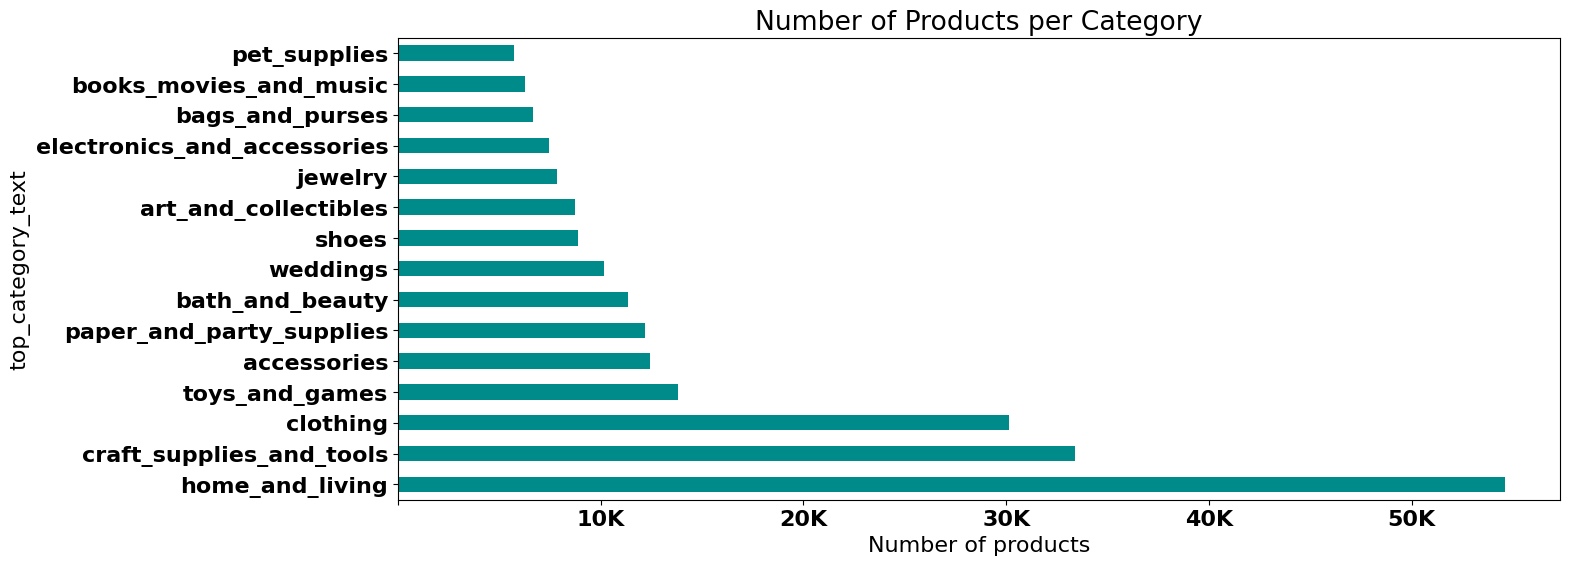

In [ ]:
figsize = (15, 6)
column = 'top_category_text'
x_limit = 60000
x_step = 10000
color = 'darkcyan'

figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_train[column],
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [ ]:
f"Number of bottom categories in train: {len(df_train['bottom_category_text'].unique()):,}"

'Number of bottom categories in train: 2,609'

### Test Dataset

The test dataset will be used to predict using the model/s you have trained

**Note** that categories and colors for the test data are hidden, you have to predict them!

In [ ]:
df_test = read_data("test", parquet_filenames_test)

In [ ]:
f'Number of rows in test: {len(df_test):,}'

'Number of rows in test: 25,514'

In [ ]:
f"Number of unique products in test: {len(df_test['product_id'].unique()):,}"

'Number of unique products in test: 25,514'

In [ ]:
f"Number of columns in test: {len(df_test.columns):,}"

'Number of columns in test: 15'

In [ ]:
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern']

In [ ]:
df_test.iloc[0]

,0
product_id,661373440
title,"Classroom Valentine Favors, Valentine Pencils,..."
description,"Valentine Favors, Robots of Love Vinyl Pencil ..."
tags,"Valentines day favor,kindergarten treats,valen..."
type,physical
room,
craft_type,kids' crafts
recipient,
material,
occasion,


## Model Training

Let's first split the data to be able to evaluate our model against a validation dataset. This validation set can also be used to fine tune your model before making the predictions on the hidden test set.

In [ ]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train,
    test_size=0.1,
    stratify=df_train['bottom_category_text'],
    random_state=42)

In [ ]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 206,661'

In [ ]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 22,963'

In [ ]:
df_training['bottom_category_text'].value_counts()

,count
bottom_category_text,
art_and_collectibles.drawing_and_illustration.architectural_drawings,88
accessories.scarves_and_wraps.scarves,88
craft_supplies_and_tools.closures_and_fasteners.buttons,88
toys_and_games.sports_and_outdoor_games.martial_arts_and_boxing.boxing_gloves,88
home_and_living.kitchen_and_dining.dining_and_serving.cake_stands,88
...,...
weddings.clothing.jumpsuits_and_rompers,40
home_and_living.furniture.entryway_furniture.standing_coat_racks,40
home_and_living.lighting.light_accessories,39


In [ ]:
df_validation['bottom_category_text'].value_counts()

In [ ]:
df_training['top_category_text'].value_counts()

,count
top_category_text,
home_and_living,49140
craft_supplies_and_tools,30056
clothing,27139
toys_and_games,12448
accessories,11173
paper_and_party_supplies,10984
bath_and_beauty,10187
weddings,9128
shoes,8001


In [ ]:
df_validation['top_category_text'].value_counts()

,count
top_category_text,
home_and_living,5460
craft_supplies_and_tools,3337
clothing,3004
toys_and_games,1387
accessories,1243
paper_and_party_supplies,1223
bath_and_beauty,1140
weddings,1015
shoes,891


### Training

As a simple example, let's follow the [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) tutorial from scikit-learn that:

- processes the text using `CountVectorizer`, that builds a dictionary of features and transforms documents to feature vectors
- extracts term frequencies and inverse document frequencies using `TfidfTransformer`, (see [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
- trains a naïve Bayes classifier, which gives us a nice baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [ ]:
train_text = df_training['title'].fillna('').values

In [ ]:
train_labels = df_training['top_category_text'].values

In [ ]:
text_clf.fit(train_text, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation

Using our validation dataset, compute a number of metrics to measure how well we generalize on our validation set.

In [ ]:
val_text = df_validation['title'].fillna('').values
val_labels = df_validation['top_category_text'].values

In [ ]:
index = 0
print(f"""
Product's title: {val_text[index][:80]}...
Prediction: '{text_clf.predict([val_text[index]])[0]}', Groundtruth: '{val_labels[index]}'
""".strip())

Product's title: Vintage enamel funnel - White metal funnel with handle - Large rusty funnel - Ki...
Prediction: 'home_and_living', Groundtruth: 'home_and_living'


In [ ]:
df_validation.iloc[0]

,1465
product_id,1085759015
title,Vintage enamel funnel - White metal funnel wit...
description,Vintage enamel funnel - White metal funnel wit...
tags,"Enamel Funnel,Vintage metal funnel,Enamelware ..."
type,physical
room,
craft_type,winemaking
recipient,
material,
occasion,


In [ ]:
val_text[:1]

array(['Vintage enamel funnel - White metal funnel with handle - Large rusty funnel - Kitchen pouring tool - Bulgarian enamelware - Old shabby chic'],
      dtype=object)

In [ ]:
predictions = text_clf.predict(val_text)

In [ ]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [ ]:
f"F1 score: {f1:.4f}"

'F1 score: 0.6392'

In [ ]:
print(metrics.classification_report(val_labels, predictions))

                             precision    recall  f1-score   support

                accessories       0.84      0.41      0.55      1243
       art_and_collectibles       0.86      0.09      0.16       870
            bags_and_purses       0.93      0.29      0.45       664
            bath_and_beauty       0.94      0.46      0.62      1140
     books_movies_and_music       0.98      0.31      0.47       626
                   clothing       0.73      0.96      0.83      3004
   craft_supplies_and_tools       0.62      0.77      0.69      3337
electronics_and_accessories       0.96      0.49      0.65       747
            home_and_living       0.54      0.96      0.69      5460
                    jewelry       0.91      0.37      0.53       782
   paper_and_party_supplies       0.80      0.58      0.67      1223
               pet_supplies       0.93      0.28      0.43       574
                      shoes       0.95      0.73      0.83       891
             toys_and_games      

In [ ]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 507,    0,    1,    4,    0,  269,  155,    0,  250,    2,    4,
           2,    2,    7,   40],
       [   5,   78,    0,    0,    0,   31,  137,    2,  593,    0,    7,
           1,    0,   12,    4],
       [   2,    0,  195,   11,    0,   44,  114,    1,  279,    0,    5,
           1,    1,    6,    5],
       [  11,    0,    4,  528,    0,   68,  129,    1,  383,    4,    3,
           1,    1,    6,    1],
       [   1,    3,    0,    0,  193,   12,   90,    4,  298,    0,   17,
           3,    0,    4,    1],
       [   7,    0,    0,    2,    1, 2894,   15,    0,   72,    1,    5,
           0,    2,    0,    5],
       [   5,    4,    0,    3,    0,   35, 2576,    1,  676,    2,   21,
           0,    4,    6,    4],
       [   1,    0,    3,    0,    1,   14,   87,  365,  259,    0,    5,
           1,    0,   11,    0],
       [   1,    4,    2,    5,    0,   44,  123,    3, 5235,    0,   27,
           2,    0,   11,    3],
       [  16,    0,    0,    2,    1,

**Note** that this is just a baseline that uses a naïve Bayes classifier and uses the `title` only as inputs, there are many more parameters that can be used in addition to multiple architectures and processing approaches

## Submission

Prepare a submission for the test data. Here I am using some dummy values, all zeros, as the ids for top categories, bottom categories, primary colors and secondary colors. Feed-forward the test data through your model, get the predictions per product and output them onto a file to be checked against the true values.

Happy Hacking!

In [ ]:
df_predictions = df_test.copy()

In [ ]:
# dummy values
df_predictions["top_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["bottom_category_id"] = np.zeros(len(df_test), dtype=int)

In [ ]:
student_id = "12345689"
df_predictions[
    ["product_id", "top_category_id", "bottom_category_id"]
].to_parquet(f"predictions_{student_id}.parquet")